### Network setup

First, let's import the relevant modules.

In [22]:
### Import relevant modules
import sys
from pathlib import Path

# add parent directory to Python path
sys.path.append(str(Path().resolve().parent))

from road import Road
from junction import Junction
from network import Network
import optimization_script_parallel

import matplotlib.pyplot as plt
import numpy as np

Let's setup the roads, the junctions, and the entire toy network.

The toy network we use is as follows:

![Toy Model](toy_model.jpg)

There is one entry road, and the entry road splits into an upper road and a lower road. The upper road then feeds into another upper road, which joins up with the lower road at the exiting junction. 

We set the entry road to have a stable car flow, while the other roads have an initial density of 0, and cars are allowed to freely exit the network at the exit road.

We view the upper roads as part of a residential area, while the lower road is an ordinary road away from the residential area. Accordingly, we set the upper roads to have a lower free flow speed and lower capacity than the lower road.

In [23]:
# Set global parameters for the roads
Road.dt = 0.1 # time step in seconds
Road.p_j = 200 # jam density in vehicles per mile

# Create 4 roads in the network
entry = Road('entry')
road2 = Road('road 2')
road3 = Road('road 3')
road4 = Road('road 4')
exit = Road('exit')

# Set parameters for the roads
entry.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.125)
entry.set_left_boundary_function(lambda time,sig: .125)

road2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)
road3.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)

road4.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=0)

exit.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)
exit.set_right_boundary_function(lambda time,sig: 0) # free outflow


# Create a junction connecting the roads
junction1 = Junction('1-in-2-out')
junction1.set_roads_in(entry).set_roads_out(road2, road4)

junction2 = Junction('1-in-1-out')
junction2.set_roads_in(road2).set_roads_out(road3)

junction3 = Junction('2-in-1-out')
junction3.set_roads_in(road3, road4).set_roads_out(exit)

# Set exit junction
junction3.set_is_exit_junction()

# Create a network with the junctions
network = Network([junction1, junction2, junction3])

# Compute initial distances from exit junction
network.compute_distances(junction3)

{1-in-2-out: 2, 1-in-1-out: 2, 2-in-1-out: 1}

In [24]:
# Create 4 roads in the network
entry_2 = Road('entry')
road2_2 = Road('road 2')
road3_2 = Road('road 3')
road4_2 = Road('road 4')
exit_2 = Road('exit')

# Set parameters for the roads
entry_2.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.125)
entry_2.set_left_boundary_function(lambda time,sig: .125) # constant inflow of 0.9 vehicles per second

road2_2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)
road3_2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)

road4_2.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=0)

exit_2.set_params(speed=20,lanes=2,length=0.5,cap=500,init_density_factor=0)
exit_2.set_right_boundary_function(lambda time,sig: 0) # free outflow


# Create a junction connecting the roads
junction1_2 = Junction('1-in-2-out')
junction1_2.set_roads_in(entry_2).set_roads_out(road2_2, road4_2)

junction2_2 = Junction('1-in-1-out')
junction2_2.set_roads_in(road2_2).set_roads_out(road3_2)

junction3_2 = Junction('2-in-1-out')
junction3_2.set_roads_in(road3_2, road4_2).set_roads_out(exit_2)

# Set exit junction
junction3_2.set_is_exit_junction()

# Create a network with the junctions
network_2 = Network([junction1_2, junction2_2, junction3_2])

# Compute initial distances from exit junction
network_2.compute_distances(junction3_2)

{1-in-2-out: 2, 1-in-1-out: 2, 2-in-1-out: 1}

We can quickly see the initial states of the roads using the `plot_current_density()` method. We confirm that the density along the entry road is at a constant 0.125, while the other roads are initialized to have density 0.

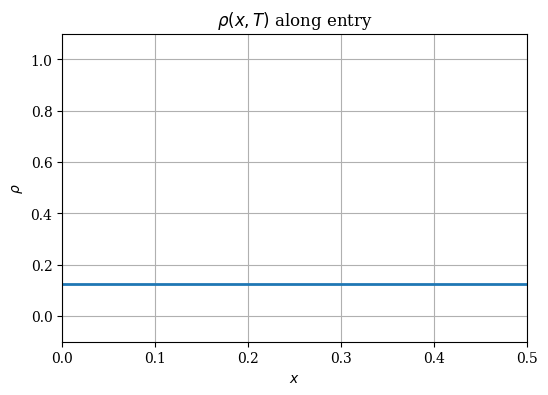

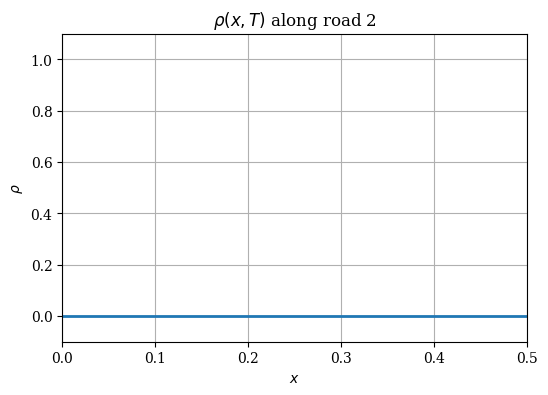

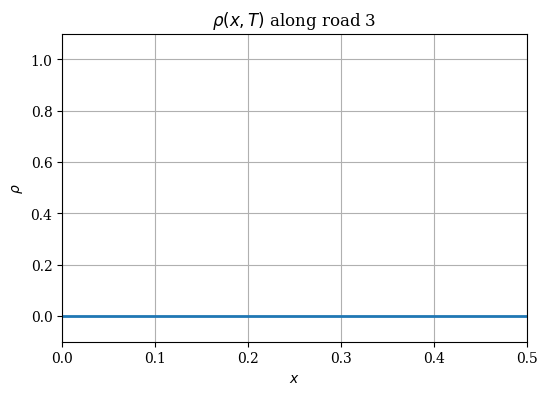

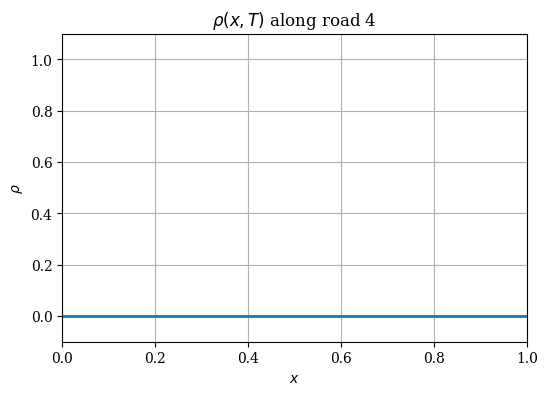

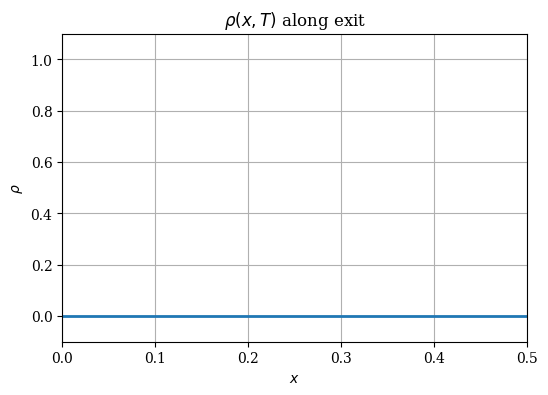

In [19]:
### Plot the roads' initial densities
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()


### Default Parameter Run

Run the network for 10000 time steps using the default parameters.

In [20]:
network.set_preferences(network.get_default_preferences())
network.reset_by_data()  # reset the network to initial conditions

# Simulate the network for 10000 time steps
for _ in range(10000):
    network.evolve_resolve(record_densities=True)

KeyboardInterrupt: 

View the results using the `plot_current_density()` function again.

With the default parameters, cars are evenly distributed at the entry junction between roads 2 and 4. Thus, we see that roads 2 and 4 similar ending density, with slight differences due to the different road parameters. Since roads 2 and 3 have the same parameters, they have very similar ending density, with any slight differences due to the time it takes cars to travel from road 2 and road 4. Finally, cars from roads 2 and 4 feed into the exit road, explaining why the exit road has a larger density compared to the other roads.

In [ ]:
### Plot the roads' densities after running with default preferences
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()

We examine some metrics for the network. 

"Weighted cars distance scaled" refers to the time integrated number of cars on the network, scaled by how far the roads are from the exit road, with roads closer to the exiting road scaled more. Here, distance to the exit road is counted by the number of junctions. Thus, road 4 is seen as closer than road 2. This distance scaling is to ensure that the metric favors cars being closer to the exit.

"Number of road segments per LOS" refers to the number of road segments at each level of service. Since we do not have many cars flowing into the network, none of the roads are congested, which corresponds to all the roads being at level of service A.

"Cars entered" and "cars exited" refer to the number of cars that entered and exited the network, respectively.

"Time-integrated cars on exit roads" refers to the time integrated number of cars on the exit road. On the other hand, "time-integrated cars on main roads" refers to the time integrated number of cars on roads that are not sources or exits. In this case, this refers to roads 2, 3, and 4.


In [ ]:
# Print metrics for network
weighted_cars = network.get_time_integrated_cars_distance_scaled()
los_count = network.count_roads_per_LOS()
cars_entered = network.get_time_integrated_cars_entered()
cars_exited = network.get_time_integrated_cars_exited()
time_int_cars_exits = network.get_time_integrated_cars_on_exit_roads()
time_int_cars_main = network.get_time_integrated_cars_on_main_roads()

print(f"Weighted cars distance scaled: {weighted_cars}")
print(f"Number of road segments per LOS: {los_count}")
print(f"Cars entered: {cars_entered}")
print(f"Cars exited: {cars_exited}")
print(f"Time-integrated cars on exit roads: {time_int_cars_exits}")
print(f"Time-integrated cars on main roads: {time_int_cars_main}")

Weighted cars distance scaled: 117.4875000000144
Number of road segments per LOS: {'A': 4, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
Cars entered: 138.88888888886538
Cars exited: 97.20833333331912
Time-integrated cars on exit roads: 46.55625000000644
Time-integrated cars on main roads: 130.19375000001304


### Optimized Parameter Run

Now let's optimize the network. Here, we run the optimization with `nt_opt_val` set to 10. This means that the loss function is the value of the metric (the time-integrated number of cars, scaled by distance) after 10 time steps of the network. Since `nt_opt_val` is such a small value, we expect the optimization to be very local, using only the starting conditions of the network. In fact, because cars closer to the exit are scaled higher, and cars in road 4 are closer by one junction, the optimization should send significantly more cars to road 4 than to road 2.

Indeed, we see that the optimal parameter value at the junction is 0.00195312, indicating that very few cars are sent to road 2.

In [43]:
for r in network.roads:
    print(r)

entry
road 2
road 4
road 3
exit


In [ ]:
### Optimize the junction preferences and re-simulate
initial_densities = [0.0325, 0.125, 0.9]
optimal_parameters = []
optimal_parameters_2 = []

optimization_script_parallel.hyperparameters[-1] = 1  # number of samples for optimization, need to pick 1 here for toy example
for init_density in initial_densities:
    print("------------")
    print("Starting optimization for initial density ", init_density)
    entry.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=init_density)
    entry.set_left_boundary_function(lambda time,sig, density=init_density: density)

    road2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=init_density)
    road3.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=init_density)

    road4.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=init_density)

    exit.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=init_density)
    exit.set_right_boundary_function(lambda time,sig: 0) # free outflow

    entry_2.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=init_density)
    entry_2.set_left_boundary_function(lambda time,sig, density=init_density: density)

    road2_2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=init_density)
    road3_2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=init_density)

    road4_2.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=init_density)

    exit_2.set_params(speed=20,lanes=2,length=0.5,cap=500,init_density_factor=init_density)
    exit_2.set_right_boundary_function(lambda time,sig: 0) # free outflow


    # for r in network_2.roads:
    #     r.set_initial_density_func(lambda x, sig = r.get_sigma(), density=init_density: density*np.ones_like(x))
    # entry_2.set_left_boundary_function(lambda time,sig,density=init_density: density)

    para = optimization_script_parallel.run_optimization(None, network, nt_opt_val=10, output_dir="", save_file=False)
    para_2 = optimization_script_parallel.run_optimization(None, network_2, nt_opt_val=10, output_dir="", save_file=False)
    
    optimal_parameters.append(para)
    optimal_parameters_2.append(para_2)

print("The optimal parameters for the single lane exit are ", optimal_parameters, ".")
print("The optimal parameters for the two lane exit are ", optimal_parameters_2, ".")

------------
Starting optimization for initial density  0.01
Using 1 processes for parallel gradient computation
Iteration Number: 1 Out of 100
Iteration 1 completed in 0.64 seconds
Iteration Number: 2 Out of 100


KeyboardInterrupt: 

Simulate the network for 10000 time steps using the optimized parameters.

In [35]:
# Run the two networks with the optimized parameters, saving the metrics for each run
weighted_cars = []
cars_exited = [] 
for i, opt_param in enumerate(optimal_parameters):
    network.set_preferences(opt_param)
    init_density = initial_densities[i]
    entry.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=init_density)
    entry.set_left_boundary_function(lambda time,sig,density=init_density: density)
    network.reset_by_data()
    # Simulate the network for 10000 time steps
    for _ in range(10000):
        network.evolve_resolve(record_densities=True)
    # Store metrics
    weighted_cars.append(network.get_time_integrated_cars_distance_scaled())
    cars_exited.append(network.get_time_integrated_cars_exited())

weighted_cars_2 = []
cars_exited_2 = [] 
for i, opt_param in enumerate(optimal_parameters_2):
    network_2.set_preferences(opt_param)
    init_density = initial_densities[i]
    entry_2.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=init_density)
    entry_2.set_left_boundary_function(lambda time,sig,density=init_density: density)
    network_2.reset_by_data()
    # Simulate the network for 10000 time steps
    for _ in range(10000):
        network_2.evolve_resolve(record_densities=True)
    # Store metrics
    weighted_cars_2.append(network_2.get_time_integrated_cars_distance_scaled())
    cars_exited_2.append(network_2.get_time_integrated_cars_exited())

Let's compare the metrics between the default parameter run and the optimal parameter run.

We see a noticeable improvement in the main metric, the time-integrated number of cars, scaled by distance. This is expected, as we specifically optimized for this metric. For the number of road segments per LOS, there is no change, as both network runs had uncongested roads, leading to every road being at level of service A. Similarly, we see that the number of cars entered is the same because the entry road cars were unimpeded in both cases, leading to cars freely flowing into the network. On the other hand, there is an increase in the number of cars exited and the time-integrated number of cars on the exit road because in the optimized parameter case, more cars are fed into road 4, which was set-up to have a higher capacity and higher free flow speed than the upper roads. Lastly, there is a decrease in the time-integrated cars on main roads, which is also expected, since an increase in the number of exiting cars implies that there are less total cars on the road.

In [36]:
# Print stored metrics and optimal parameters
print("Metrics for single lane exit:")
for i, init_density in enumerate(initial_densities):
    print(f"Initial density: {init_density}, Weighted cars distance scaled: {weighted_cars[i]}, Cars exited: {cars_exited[i]}")
print("Optimal parameters:", [x.item() for x in optimal_parameters])
print("Metrics for two lane exit:")
for i, init_density in enumerate(initial_densities):
    print(f"Initial density: {init_density}, Weighted cars distance scaled: {weighted_cars_2[i]}, Cars exited: {cars_exited_2[i]}")
print("Optimal parameters:", [x.item() for x in optimal_parameters_2])

Metrics for single lane exit:
Initial density: 0.03125, Weighted cars distance scaled: 1007.5724850769756, Cars exited: 138.8779931972554
Initial density: 0.125, Weighted cars distance scaled: 1089.4608809153594, Cars exited: 138.8779931972554
Initial density: 0.9, Weighted cars distance scaled: 1126.086372878729, Cars exited: 138.8779931972554
Optimal parameters: [0.5, 0.5, 0.5]
Metrics for two lane exit:
Initial density: 0.03125, Weighted cars distance scaled: 1180.604778241801, Cars exited: 277.7559863945108
Initial density: 0.125, Weighted cars distance scaled: 1263.4572655023687, Cars exited: 277.7559863945108
Initial density: 0.9, Weighted cars distance scaled: 1300.0827574657378, Cars exited: 277.7559863945108
Optimal parameters: [0.5, 0.5, 0.5]


We view the ending densities of all the roads, confirming that none of the roads are congested.

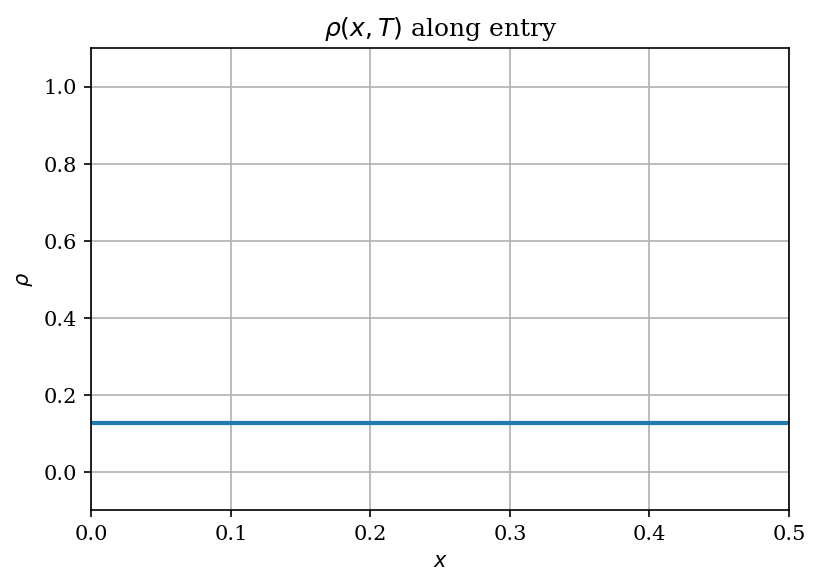

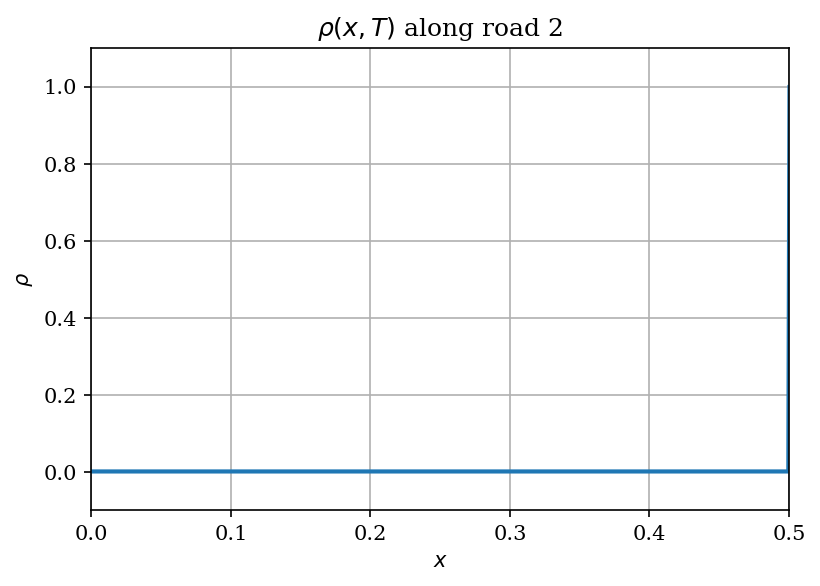

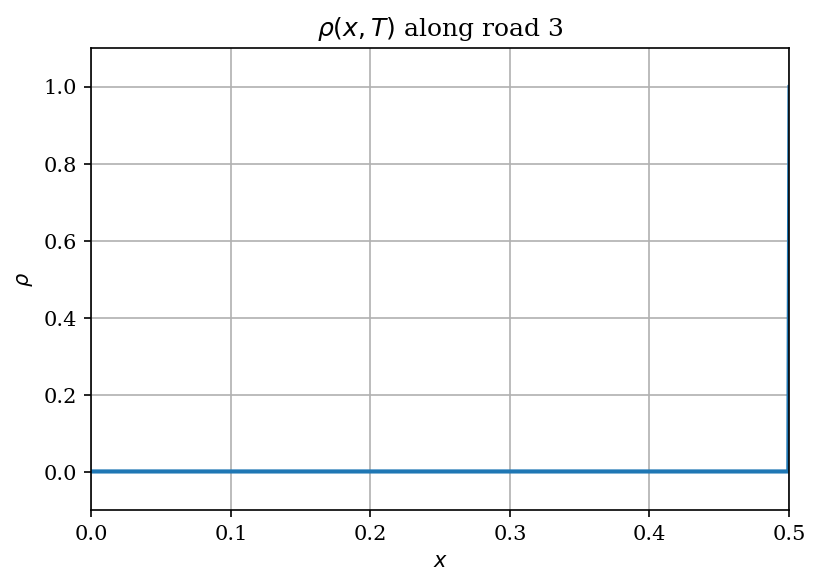

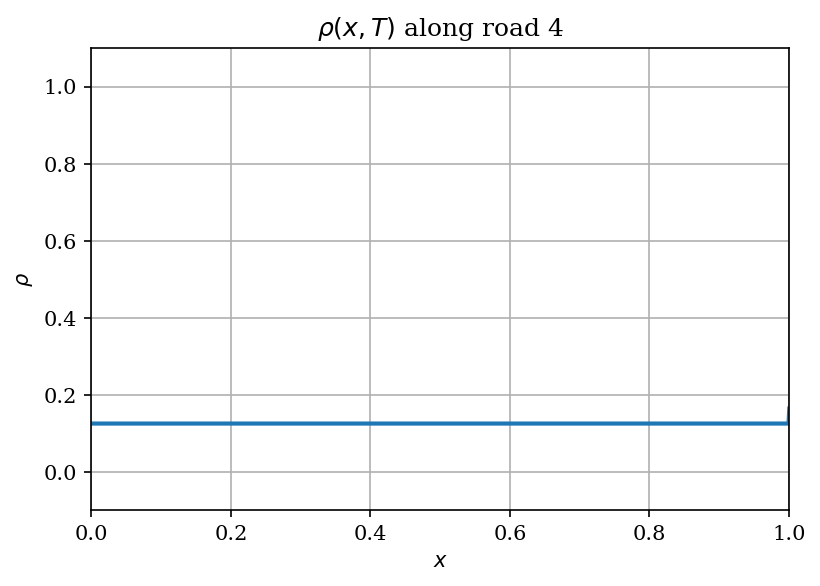

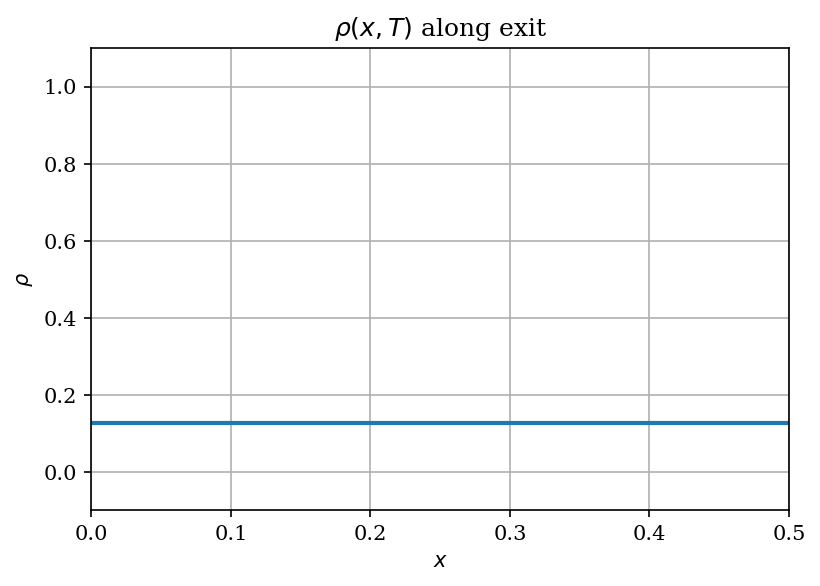

In [131]:
### Plot the roads' densities after simulating with optimal parameters
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()

Store the optimized run for each road as a gif.

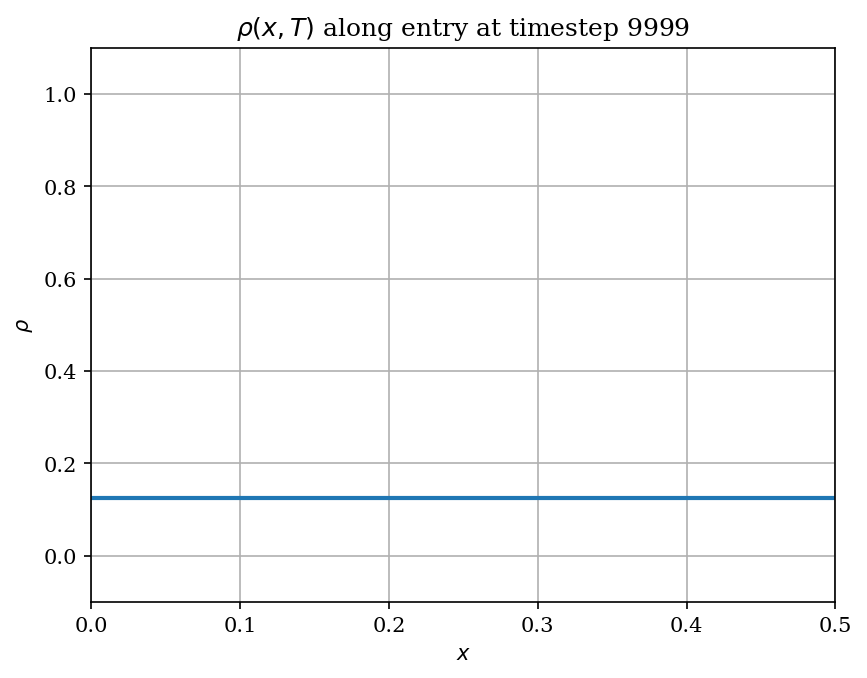

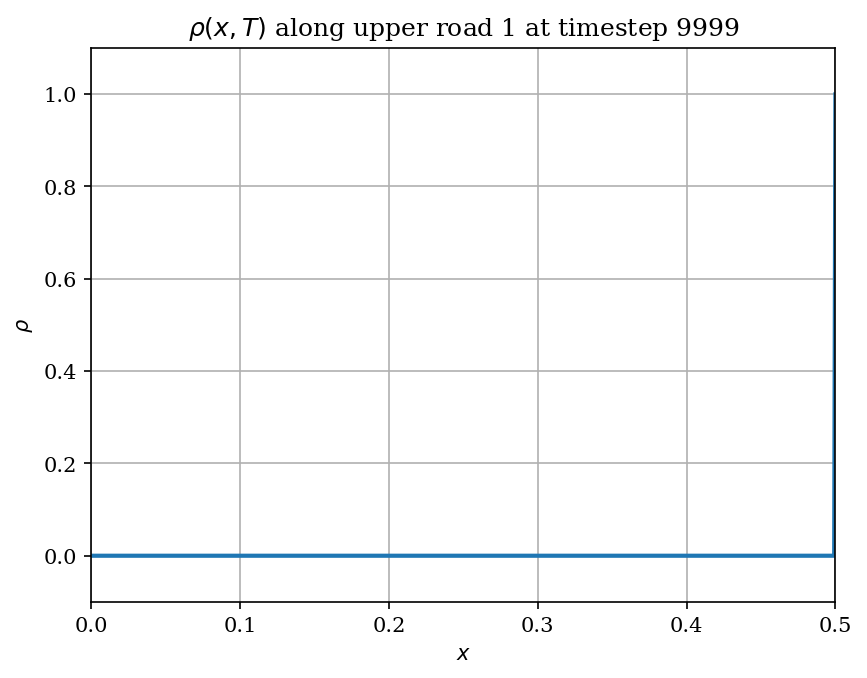

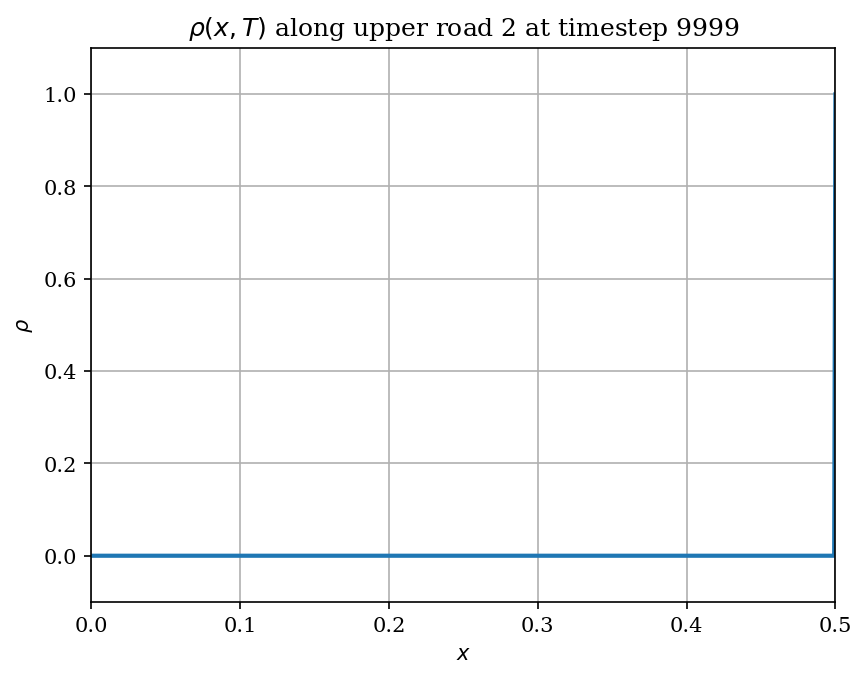

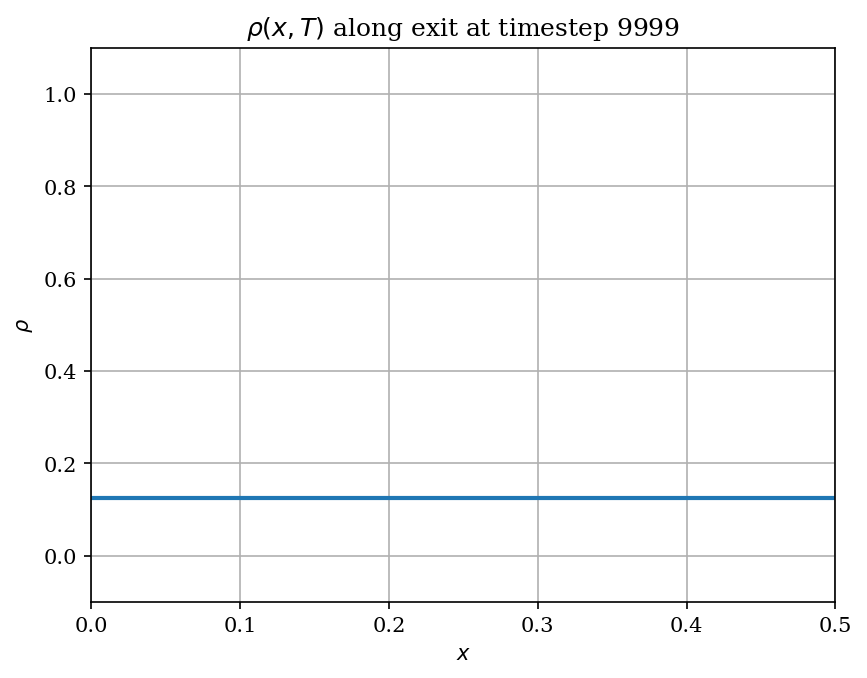

In [ ]:
# Animate the road's densities over time
entry.animate_density_history("entry_animation.gif")
road2.animate_density_history("road2_animation.gif")
road3.animate_density_history("road3_animation.gif")
road4.animate_density_history("road4_animation.gif")
exit.animate_density_history("exit_animation.gif")